# **What are Content Recommender Systems?**
According to Wikipedia:

“Recommender systems or recommendation systems (sometimes replacing “system” with a synonym such as platform or engine) are a subclass of information filtering system that seek to predict the ‘rating’ or ‘preference’ that user would give to an item.”

![](https://image.slidesharecdn.com/contentbasedfiltering-140722025107-phpapp01/95/content-based-filtering-1-638.jpg?cb=1405998926)

# **TMDB**
The Movie Database, also known as TMDB, is a database that contains detailed information on over 500,000 movies. The Movies dataframe has links to the movie posters in it, but the vast majority of them are outdated and no longer work. In order to find the poster links, the tmdbsimple library, which acts as a Python wrapper for the TMDB API was used. The ID of the movie is all that it takes to obtain that movie's updated information. The TMDB website has a simple structure to its URLs, therefore getting the link to each movie's page involves taking the base site link and adding the id of the movie, a dash, and the movie title.

![](http://miro.medium.com/max/8174/1*y1D9OyNtARhP0jrVmvULTw.jpeg)

# **Loading Libraries and Data**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import pickle

In [2]:
'''load training dataset'''
movies = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv') 

In [3]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [4]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


**Aggregate data into a single file**

In [5]:
movies = movies.merge(credits,on='title')
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [6]:
movies.shape

(4809, 23)

**select useful feature **

**I will select: **
1. movie_id
2. title
3. overview
4. genres
5. keywords
6. cast
7. crew

In [7]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]
movies.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [8]:
movies.shape

(4809, 7)

# **handling with missing values**

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64


<AxesSubplot:>

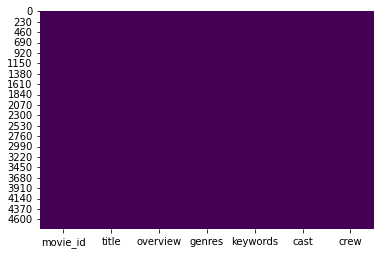

In [9]:
print(movies.isnull().sum())
sns.heatmap(movies.isnull(),cbar=False, cmap='viridis')

In [10]:
movies.dropna(inplace=True)

In [11]:
movies.isnull().sum()

movie_id    0
title       0
overview    0
genres      0
keywords    0
cast        0
crew        0
dtype: int64

we are good 

# **Data Cleaning**

Safely evaluate an expression node or a Unicode or Latin-1 encoded string containing a Python expression

In [12]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L

**apply on data**

In [13]:
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert)

In [14]:
movies.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


**but we will take only first 3 actors from cast**

In [15]:
movies['cast'] = movies['cast'].apply(lambda x:x[0:3])

In [16]:
movies['cast'].head()

0    [Sam Worthington, Zoe Saldana, Sigourney Weaver]
1       [Johnny Depp, Orlando Bloom, Keira Knightley]
2        [Daniel Craig, Christoph Waltz, Léa Seydoux]
3        [Christian Bale, Michael Caine, Gary Oldman]
4      [Taylor Kitsch, Lynn Collins, Samantha Morton]
Name: cast, dtype: object

**fetch director from crew data**

In [17]:
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L

In [18]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [19]:
movies['crew'].head()

0        [James Cameron]
1       [Gore Verbinski]
2           [Sam Mendes]
3    [Christopher Nolan]
4       [Andrew Stanton]
Name: crew, dtype: object

**collapse blanks on data**

In [20]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [21]:
movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

In [22]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


**split 'overview' contet**

In [23]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())

In [24]:
movies['overview'].head()

0    [In, the, 22nd, century,, a, paraplegic, Marin...
1    [Captain, Barbossa,, long, believed, to, be, d...
2    [A, cryptic, message, from, Bond’s, past, send...
3    [Following, the, death, of, District, Attorney...
4    [John, Carter, is, a, war-weary,, former, mili...
Name: overview, dtype: object

# **Combine texts in one column **

In [25]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [26]:
movies['tags'].head()

0    [In, the, 22nd, century,, a, paraplegic, Marin...
1    [Captain, Barbossa,, long, believed, to, be, d...
2    [A, cryptic, message, from, Bond’s, past, send...
3    [Following, the, death, of, District, Attorney...
4    [John, Carter, is, a, war-weary,, former, mili...
Name: tags, dtype: object

**remove old columns and create new data with id and title**

In [27]:
new = movies.drop(columns=['overview','genres','keywords','cast','crew'])
new.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


**splitting recovery after combine data on tag column**

In [28]:
new['tags'] = new['tags'].apply(lambda x: " ".join(x))
new['tags'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: tags, dtype: object

# **Vectorizer applying on 'tags'**

In [29]:
lv = TfidfVectorizer(max_features=5000,stop_words='english')

In [30]:
vector = lv.fit_transform(new['tags']).toarray()

# **Cosine Similarity**

**Cosine Similarity is: **
* a measure of similarity between two non-zero vectors of an inner product space
* the cosine of the trigonometric angle between two vectors
* the inner product of two vectors normalized to length 1
* applied to vectors of low and high dimensionality
* not a measure of vector magnitude, just the angle between vectors

![](https://images.squarespace-cdn.com/content/v1/5acbdd3a25bf024c12f4c8b4/1601861231635-6FB41TNOOPTVI7RXT7DF/Cosine+Similarity+Radial+Examples.png)

In [31]:
similarity = cosine_similarity(vector)

In [32]:
print(similarity)

[[1.         0.02246322 0.01284023 ... 0.00565329 0.00610902 0.        ]
 [0.02246322 1.         0.0128045  ... 0.01761983 0.         0.        ]
 [0.01284023 0.0128045  1.         ... 0.01700739 0.         0.        ]
 ...
 [0.00565329 0.01761983 0.01700739 ... 1.         0.02899316 0.03339605]
 [0.00610902 0.         0.         ... 0.02899316 1.         0.01671894]
 [0.         0.         0.         ... 0.03339605 0.01671894 1.        ]]


# **Recommender Function**

**it will recommend only 5 movies which have highst 'cosine_similarity' with the choice movie**

In [33]:
def recommend(movie):
    index = new[new['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(new.iloc[i[0]].title)

# ***test***

In [34]:
recommend('Spectre')

Quantum of Solace
Never Say Never Again
Skyfall
Thunderball
Restless


In [35]:
# pickle.dump(new,open('movie_list.pkl','wb'))
# pickle.dump(similarity,open('similarity.pkl','wb'))